In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, LSTM, Bidirectional, concatenate, Flatten, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, auc
from sklearn.metrics import roc_curve
from tensorflow.keras.models import Model

# Звгрузка датасета и деление на выборки

In [4]:
df = pd.read_csv('/kaggle/input/dataset-fishing-site/updated_dataset06-04-25.csv', sep="\t")

# разделяем данные на текстовые, числовые признаки и метки
X_text = df['Text Content'].values
X_numeric = df[['url_length', 'num_subdomains', 'has_hyphen',
                'has_https', 'domain_length', 'phishing_keywords_in_url',
                'phishing_keywords_in_text', 'text_length']].values
y = df['Label'].values

# преобразуем текст в последовательности чисел
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_text)
X_seq = tokenizer.texts_to_sequences(X_text)
X_pad = pad_sequences(X_seq, maxlen=200)
# нормализуем числовые признаки
scaler = StandardScaler()
X_numeric = scaler.fit_transform(X_numeric)
# кодируем метки
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [5]:
# настраиваем кросс-валидцию
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
f1_scores = []
roc_auc_scores = []
all_histories = []
all_models = []

# начинаем обучение на каждом фолде
for fold, (train_idx, test_idx) in enumerate(kfold.split(X_pad, y)):
    print(f"\n{'='*50}\nFold {fold + 1}\n{'='*50}")
    
    # разделяем данные на обучающую и тестовую
    X_train_text, X_test_text = X_pad[train_idx], X_pad[test_idx]
    X_train_num, X_test_num = X_numeric[train_idx], X_numeric[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # вычисляем веса классов для балансировки
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y_train)
    class_weights = dict(enumerate(class_weights))
    
    # создаем модель нейросети и вход для текста
    text_input = Input(shape=(200,), name='text_input')
    embedding = Embedding(input_dim=10000, output_dim=128, input_length=200)(text_input)
    conv1 = Conv1D(128, 5, activation='relu')(embedding)
    pool1 = MaxPooling1D(5)(conv1)
    conv2 = Conv1D(128, 5, activation='relu')(pool1)
    pool2 = MaxPooling1D(5)(conv2)
    lstm = Bidirectional(LSTM(64))(pool2)
    
    # вход для числовых признаков
    num_input = Input(shape=(X_numeric.shape[1],), name='num_input')
    dense_num = Dense(64, activation='relu')(num_input)
    
    # объединяем оба входа
    merged = concatenate([lstm, dense_num])
    dropout = Dropout(0.7)(merged)
    dense1 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dropout)
    output = Dense(1, activation='sigmoid')(dense1)

    model = Model(inputs=[text_input, num_input], outputs=output)
    
    # настраиваем оптимизатор и компилируем модель
    optimizer = AdamW(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # добавляем callback
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    ]

    # обучаем модель
    history = model.fit(
        [X_train_text, X_train_num], y_train,
        epochs=70,
        batch_size=64,
        validation_data=([X_test_text, X_test_num], y_test),
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

    # сохраняем модель и историю обучения
    all_models.append(model)
    all_histories.append(history)

    # делаем предсказания и вычисляем метрики
    y_pred = model.predict([X_test_text, X_test_num])
    y_pred_classes = (y_pred > 0.5).astype(int)

    f1 = f1_score(y_test, y_pred_classes)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    # выводим отчет по классификации
    print(f"\nClassification Report for Fold {fold + 1}:")
    print(classification_report(y_test, y_pred_classes))
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")

# выводим итоговые результаты по всем фолдам
print("\n" + "="*50)
print("Final Results")
print("="*50)
print(f"Average F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Average ROC AUC Score: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")

# находим лучшую модель
best_fold_idx = np.argmax(f1_scores)
print(f"\nBest fold is {best_fold_idx + 1} with F1-score: {f1_scores[best_fold_idx]:.4f}")


Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1747483120.027991      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/70


I0000 00:00:1747483127.500123     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.3975 - loss: 1.6704 - val_accuracy: 0.5195 - val_loss: 1.6287 - learning_rate: 1.0000e-04
Epoch 2/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4730 - loss: 1.6209 - val_accuracy: 0.6883 - val_loss: 1.5932 - learning_rate: 1.0000e-04
Epoch 3/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5487 - loss: 1.5901 - val_accuracy: 0.7273 - val_loss: 1.5577 - learning_rate: 1.0000e-04
Epoch 4/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5617 - loss: 1.5673 - val_accuracy: 0.7792 - val_loss: 1.5233 - learning_rate: 1.0000e-04
Epoch 5/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5892 - loss: 1.5404 - val_accuracy: 0.8312 - val_loss: 1.4862 - learning_rate: 1.0000e-04
Epoch 6/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6860 - loss: 1.4971 - val_accuracy: 0.8442 - val_loss: 1.4453 - learning_rate: 1.0000e-04
Epoch 7/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7098 - loss: 1.4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.5803 - loss: 1.6507 - val_accuracy: 0.6711 - val_loss: 1.6021 - learning_rate: 1.0000e-04
Epoch 2/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6439 - loss: 1.6138 - val_accuracy: 0.7895 - val_loss: 1.5673 - learning_rate: 1.0000e-04
Epoch 3/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7017 - loss: 1.5696 - val_accuracy: 0.8421 - val_loss: 1.5317 - learning_rate: 1.0000e-04
Epoch 4/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7377 - loss: 1.5342 - val_accuracy: 0.8158 - val_loss: 1.4971 - learning_rate: 1.0000e-04
Epoch 5/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7299 - loss: 1.5108 - val_accuracy: 0.8289 - val_loss: 1.4599 - learning_rate: 1.0000e-04
Epoch 6/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7892 - loss: 1.4618 - val_accuracy: 0.8421 - val_loss: 1.4209 - learning_rate: 1.0000e-04
Epoch 7/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8148 - loss: 1.4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.4410 - loss: 1.7165 - val_accuracy: 0.2368 - val_loss: 1.7169 - learning_rate: 1.0000e-04
Epoch 2/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4477 - loss: 1.6786 - val_accuracy: 0.4342 - val_loss: 1.6777 - learning_rate: 1.0000e-04
Epoch 3/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5164 - loss: 1.6317 - val_accuracy: 0.4605 - val_loss: 1.6362 - learning_rate: 1.0000e-04
Epoch 4/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5763 - loss: 1.5778 - val_accuracy: 0.5132 - val_loss: 1.5957 - learning_rate: 1.0000e-04
Epoch 5/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6466 - loss: 1.5675 - val_accuracy: 0.5789 - val_loss: 1.5549 - learning_rate: 1.0000e-04
Epoch 6/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6716 - loss: 1.5004 - val_accuracy: 0.6316 - val_loss: 1.5083 - learning_rate: 1.0000e-04
Epoch 7/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7140 - loss: 1.4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.3187 - loss: 1.7224 - val_accuracy: 0.4079 - val_loss: 1.6590 - learning_rate: 1.0000e-04
Epoch 2/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3540 - loss: 1.6702 - val_accuracy: 0.6316 - val_loss: 1.6207 - learning_rate: 1.0000e-04
Epoch 3/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4325 - loss: 1.6382 - val_accuracy: 0.7632 - val_loss: 1.5858 - learning_rate: 1.0000e-04
Epoch 4/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4624 - loss: 1.6085 - val_accuracy: 0.8289 - val_loss: 1.5498 - learning_rate: 1.0000e-04
Epoch 5/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5536 - loss: 1.5624 - val_accuracy: 0.8289 - val_loss: 1.5132 - learning_rate: 1.0000e-04
Epoch 6/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5997 - loss: 1.5205 - val_accuracy: 0.8026 - val_loss: 1.4732 - learning_rate: 1.0000e-04
Epoch 7/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6980 - loss: 1.4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.6271 - loss: 1.6205 - val_accuracy: 0.7105 - val_loss: 1.6205 - learning_rate: 1.0000e-04
Epoch 2/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6107 - loss: 1.6018 - val_accuracy: 0.7368 - val_loss: 1.5801 - learning_rate: 1.0000e-04
Epoch 3/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6344 - loss: 1.5672 - val_accuracy: 0.7895 - val_loss: 1.5391 - learning_rate: 1.0000e-04
Epoch 4/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6644 - loss: 1.5516 - val_accuracy: 0.8026 - val_loss: 1.4965 - learning_rate: 1.0000e-04
Epoch 5/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7323 - loss: 1.4957 - val_accuracy: 0.8553 - val_loss: 1.4475 - learning_rate: 1.0000e-04
Epoch 6/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7769 - loss: 1.4676 - val_accuracy: 0.9079 - val_loss: 1.3892 - learning_rate: 1.0000e-04
Epoch 7/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8184 - loss: 1.4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.5519 - loss: 1.6267 - val_accuracy: 0.7368 - val_loss: 1.5887 - learning_rate: 1.0000e-04
Epoch 2/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6231 - loss: 1.5985 - val_accuracy: 0.7500 - val_loss: 1.5535 - learning_rate: 1.0000e-04
Epoch 3/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6690 - loss: 1.5597 - val_accuracy: 0.7500 - val_loss: 1.5172 - learning_rate: 1.0000e-04
Epoch 4/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7240 - loss: 1.5340 - val_accuracy: 0.7500 - val_loss: 1.4834 - learning_rate: 1.0000e-04
Epoch 5/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8045 - loss: 1.4852 - val_accuracy: 0.7895 - val_loss: 1.4470 - learning_rate: 1.0000e-04
Epoch 6/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8004 - loss: 1.4663 - val_accuracy: 0.8026 - val_loss: 1.4079 - learning_rate: 1.0000e-04
Epoch 7/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8126 - loss: 1.4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6602 - loss: 1.6117 - val_accuracy: 0.6842 - val_loss: 1.5483 - learning_rate: 1.0000e-04
Epoch 2/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7000 - loss: 1.5577 - val_accuracy: 0.7895 - val_loss: 1.5135 - learning_rate: 1.0000e-04
Epoch 3/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7234 - loss: 1.5601 - val_accuracy: 0.8816 - val_loss: 1.4813 - learning_rate: 1.0000e-04
Epoch 4/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7904 - loss: 1.4905 - val_accuracy: 0.8553 - val_loss: 1.4495 - learning_rate: 1.0000e-04
Epoch 5/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7944 - loss: 1.4543 - val_accuracy: 0.8947 - val_loss: 1.4170 - learning_rate: 1.0000e-04
Epoch 6/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8010 - loss: 1.4410 - val_accuracy: 0.8553 - val_loss: 1.3864 - learning_rate: 1.0000e-04
Epoch 7/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7990 - loss: 1.3

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.4104 - loss: 1.6589 - val_accuracy: 0.5658 - val_loss: 1.6264 - learning_rate: 1.0000e-04
Epoch 2/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4567 - loss: 1.6378 - val_accuracy: 0.6974 - val_loss: 1.5852 - learning_rate: 1.0000e-04
Epoch 3/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5290 - loss: 1.5881 - val_accuracy: 0.8158 - val_loss: 1.5423 - learning_rate: 1.0000e-04
Epoch 4/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5534 - loss: 1.5562 - val_accuracy: 0.8553 - val_loss: 1.4972 - learning_rate: 1.0000e-04
Epoch 5/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6480 - loss: 1.5194 - val_accuracy: 0.9342 - val_loss: 1.4463 - learning_rate: 1.0000e-04
Epoch 6/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7059 - loss: 1.4738 - val_accuracy: 0.9474 - val_loss: 1.3830 - learning_rate: 1.0000e-04
Epoch 7/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7616 - loss: 1.4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.4572 - loss: 1.6935 - val_accuracy: 0.5526 - val_loss: 1.6378 - learning_rate: 1.0000e-04
Epoch 2/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5282 - loss: 1.6518 - val_accuracy: 0.7500 - val_loss: 1.6042 - learning_rate: 1.0000e-04
Epoch 3/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6020 - loss: 1.6072 - val_accuracy: 0.7763 - val_loss: 1.5688 - learning_rate: 1.0000e-04
Epoch 4/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5950 - loss: 1.5816 - val_accuracy: 0.8026 - val_loss: 1.5314 - learning_rate: 1.0000e-04
Epoch 5/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7071 - loss: 1.5322 - val_accuracy: 0.7895 - val_loss: 1.4923 - learning_rate: 1.0000e-04
Epoch 6/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7369 - loss: 1.4947 - val_accuracy: 0.7895 - val_loss: 1.4460 - learning_rate: 1.0000e-04
Epoch 7/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7749 - loss: 1.4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.4286 - loss: 1.6677 - val_accuracy: 0.4737 - val_loss: 1.6320 - learning_rate: 1.0000e-04
Epoch 2/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4499 - loss: 1.6414 - val_accuracy: 0.5658 - val_loss: 1.5942 - learning_rate: 1.0000e-04
Epoch 3/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5224 - loss: 1.5991 - val_accuracy: 0.6447 - val_loss: 1.5588 - learning_rate: 1.0000e-04
Epoch 4/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5695 - loss: 1.5721 - val_accuracy: 0.7368 - val_loss: 1.5246 - learning_rate: 1.0000e-04
Epoch 5/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6269 - loss: 1.5299 - val_accuracy: 0.7763 - val_loss: 1.4877 - learning_rate: 1.0000e-04
Epoch 6/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6848 - loss: 1.4742 - val_accuracy: 0.8026 - val_loss: 1.4442 - learning_rate: 1.0000e-04
Epoch 7/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7258 - loss: 1.4

In [15]:
# функция для отображения истории обученя
def plot_training_history(history, fold):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold + 1} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Тhe best fold:
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


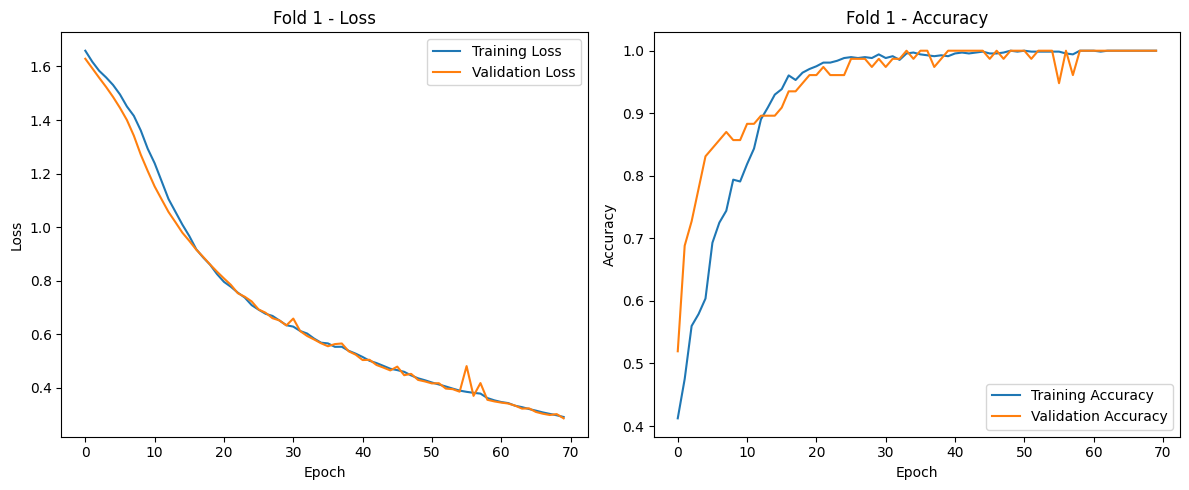

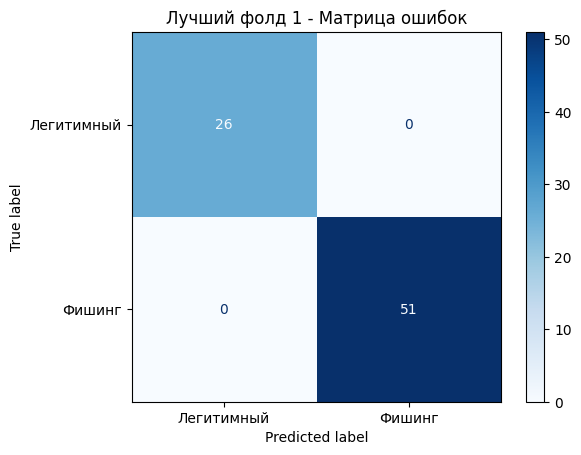

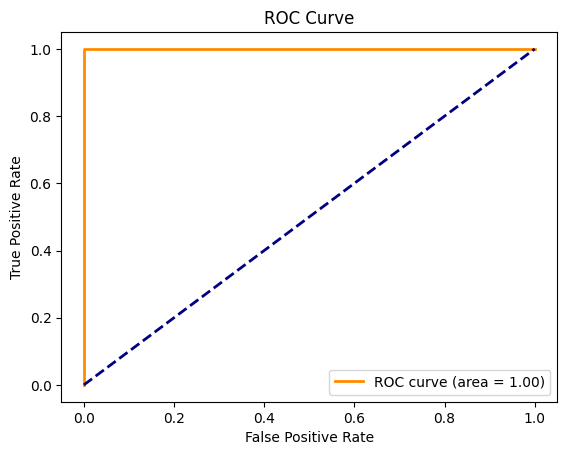

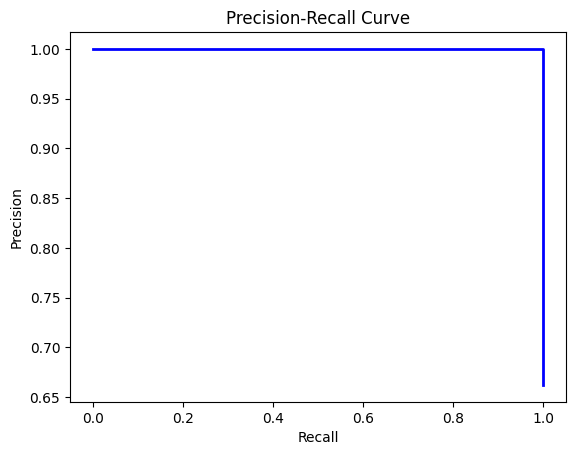


Анализ важности признаков:


In [7]:
# анализируем лучшую модель
print("\nТhe best fold:")
best_model = all_models[best_fold_idx]
best_history = all_histories[best_fold_idx]

_, test_idx = list(kfold.split(X_pad, y))[best_fold_idx]
X_test_text_best = X_pad[test_idx]
X_test_num_best = X_numeric[test_idx]
y_test_best = y[test_idx]

y_pred_best = best_model.predict([X_test_text_best, X_test_num_best])
y_pred_classes_best = (y_pred_best > 0.5).astype(int)

# выводим графики обучения для лучшей моделм
plot_training_history(best_history, best_fold_idx)

# выводим confmatrix
cm = confusion_matrix(y_test_best, y_pred_classes_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Легитимный', 'Фишинг'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Лучший фолд {best_fold_idx + 1} - Матрица ошибок')
plt.show()

# выводим ROC-кривую
fpr, tpr, _ = roc_curve(y_test_best, y_pred_best)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# выводим precision-recall кривую
precision, recall, _ = precision_recall_curve(y_test_best, y_pred_best)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()



In [12]:
# анализ важности признаков
print("\nАнализ важности признаков:")
#  Важность слов из Embedding слоя
embedding_layer = best_model.layers[1]
embedding_weights = embedding_layer.get_weights()[0]
word_importance = np.linalg.norm(embedding_weights, axis=1)


word_index = tokenizer.word_index
reverse_word_index = {v: k for k, v in word_index.items()}

# ттоп-10 важных слов
top_word_indices = np.argsort(word_importance)[-10:][::-1]

print("\nТоп-10 важных слов (по норме вектора embedding):")
for idx in top_word_indices:
    word = reverse_word_index.get(idx + 1, 'UNK')
    print(f"{word}: {word_importance[idx]:.4f}")

dense_num_layer = [layer for layer in best_model.layers if layer.name.startswith('dense')][0]
numeric_weights = dense_num_layer.get_weights()[0]

numeric_feature_names = ['url_length', 'num_subdomains', 'has_hyphen',
                        'has_https', 'domain_length', 'phishing_keywords_in_url',
                        'phishing_keywords_in_text', 'text_length']

print("\nВажность числовых признаков:")
for name, imp in zip(numeric_feature_names, np.mean(np.abs(numeric_weights), axis=1)):
    print(f"{name}: {imp:.4f}")


Анализ важности признаков:

Топ-10 важных слов (по норме вектора embedding):
вход: 0.6994
girls: 0.6465
xrp: 0.5797
on: 0.5459
2: 0.5372
source: 0.5356
shop: 0.5303
a: 0.5269
home: 0.5244
privacy: 0.5239

Важность числовых признаков:
url_length: 0.1522
num_subdomains: 0.1409
has_hyphen: 0.1481
has_https: 0.1592
domain_length: 0.1299
phishing_keywords_in_url: 0.1515
phishing_keywords_in_text: 0.1243
text_length: 0.1490


In [10]:
import pandas as pd


df = pd.read_csv('/kaggle/input/dataset-fishing-site/updated_dataset06-04-25.csv', sep='\t')


duplicates = df.duplicated()
print(f"Всего дубликатов: {duplicates.sum()}")
print("Примеры дубликатов:")
print(df[duplicates].head())
df_clean = df.drop_duplicates()
print(f"Размер до очистки: {df.shape}, после очистки: {df_clean.shape}")
df_clean.to_csv('updated_dataset06-04-25.csv', sep='\t', index=False)

Всего дубликатов: 0
Примеры дубликатов:
Empty DataFrame
Columns: [URL, Text Content, Label, url_length, num_subdomains, has_hyphen, has_https, domain_length, phishing_keywords_in_url, phishing_keywords_in_text, text_length]
Index: []
Размер до очистки: (761, 11), после очистки: (761, 11)
